In [1]:
import numpy as np
from tensorflow import set_random_seed
from numpy.random import seed
import pandas as pd
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import datetime
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#dataset_empty = 0
set_random_seed(1)
seed(1)

In [3]:
#Convert the train data into time series
def time_series_data(data, window, lag):
    dropnan = True
    cols, names = list(), list()

    for i in range(window, 0, -1):
        #past time series data (t-)
        cols.append(data.shift(i))
        names = names + [('%s(t-%d)' % (col, i)) for col in data.columns]
    
    #current time series data (t = 0)
    cols.append(data)
    names = names + [('%s(t)' % (col)) for col in data.columns]
    
    #future data (t + lag)
    cols.append(data.shift(-lag))
    names = names + [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    #all data
    all_data = pd.concat(cols, axis=1)
    all_data.columns = names
    
    #drops rows with NaN
    if dropnan:
        all_data.dropna(inplace=True)
    return all_data

In [4]:
dataset = pd.read_csv('sales data-set.csv', usecols = ['Store', 'Item', 'Date', 'Weekly_Sales'])
train = dataset[['Store', 'Item', 'Date', 'Weekly_Sales']]
#train = train.loc[(train['Store'] == 1) & (train['Item'] == 1)]
#train = train[(train['Date'] >= '2012-01-01')]
#train = train.loc[train['Store'] == 1]

print(train.head())

   Store  Item        Date  Weekly_Sales
0      1     1  2010-02-07      24924.50
1      1     2  2010-02-07      50605.27
2      1     3  2010-02-07      13740.12
3      1     4  2010-02-07      39954.04
4      1     5  2010-02-07      32229.38


In [5]:
#Re-arranges the train dataset to apply shift methods
train_r = train.sort_values('Date').groupby(['Item', 'Store', 'Date'], as_index=False)
train_r = train_r.agg({'Weekly_Sales':['mean']})
train_r.columns = ['Item', 'Store', 'Date', 'Weekly_Sales']
#cols_to_drop = ['Date']
#train_r.drop(cols_to_drop, axis=1, inplace=True)
train_r.head()

,Item,Store,Date,Weekly_Sales
0,1,1,2010-02-07,24924.50
1,1,1,2010-02-14,46039.49
2,1,1,2010-02-21,41595.55
3,1,1,2010-02-28,19403.54
4,1,1,2010-03-07,21827.90


In [6]:
train_r = train_r.groupby(['Date'], as_index=False)['Weekly_Sales'].sum()
train_r.head()

,Date,Weekly_Sales
0,2010-02-07,49750740.50
1,2010-02-14,48336677.63
2,2010-02-21,48276993.78
3,2010-02-28,43968571.13
4,2010-03-07,46871470.30


In [7]:
#weekly sales in 100 million dollars
train_r['Weekly_Sales'] = train_r['Weekly_Sales'] / 10000000
train_r.head()

,Date,Weekly_Sales
0,2010-02-07,4.975074
1,2010-02-14,4.833668
2,2010-02-21,4.827699
3,2010-02-28,4.396857
4,2010-03-07,4.687147


In [8]:
#the model will use last 117 weekly sales data and 
#current timestep (7 days) to forecast next weekly sales data 12 weeks ahead

window = 117
lag = 12

series_data = time_series_data(train_r, window, lag)
series_data.head()

,Date(t-117),Weekly_Sales(t-117),Date(t-116),Weekly_Sales(t-116),Date(t-115),Weekly_Sales(t-115),Date(t-114),Weekly_Sales(t-114),Date(t-113),Weekly_Sales(t-113),...,Date(t-3),Weekly_Sales(t-3),Date(t-2),Weekly_Sales(t-2),Date(t-1),Weekly_Sales(t-1),Date(t),Weekly_Sales(t),Date(t+12),Weekly_Sales(t+12)
117,2010-02-07,4.975074,2010-02-14,4.833668,2010-02-21,4.827699,2010-02-28,4.396857,2010-03-07,4.687147,...,2012-04-15,4.662926,2012-04-22,4.507253,2012-04-29,4.371680,2012-05-06,4.712420,2012-07-29,4.409715
118,2010-02-14,4.833668,2010-02-21,4.827699,2010-02-28,4.396857,2010-03-07,4.687147,2010-03-14,4.592540,...,2012-04-22,4.507253,2012-04-29,4.371680,2012-05-06,4.712420,2012-05-13,4.692588,2012-08-05,4.748590
119,2010-02-21,4.827699,2010-02-28,4.396857,2010-03-07,4.687147,2010-03-14,4.592540,2010-03-21,4.498897,...,2012-04-29,4.371680,2012-05-06,4.712420,2012-05-13,4.692588,2012-05-20,4.682394,2012-08-12,4.740345
120,2010-02-28,4.396857,2010-03-07,4.687147,2010-03-14,4.592540,2010-03-21,4.498897,2010-03-28,4.413396,...,2012-05-06,4.712420,2012-05-13,4.692588,2012-05-20,4.682394,2012-05-27,4.789246,2012-08-19,4.735445
121,2010-03-07,4.687147,2010-03-14,4.592540,2010-03-21,4.498897,2010-03-28,4.413396,2010-04-04,5.042383,...,2012-05-13,4.692588,2012-05-20,4.682394,2012-05-27,4.789246,2012-06-03,4.828165,2012-08-26,4.744732


In [9]:
future_dates = series_data[['Date(t+%d)' % lag]]
future_dates

,Date(t+12)
117,2012-07-29
118,2012-08-05
119,2012-08-12
120,2012-08-19
121,2012-08-26
122,2012-09-02
123,2012-09-09
124,2012-09-16
125,2012-09-23
126,2012-09-30


In [10]:
#drops last record of (t + lag)
#last_record_item = 'Item(t-%d)' % window
#last_record_store = 'Store(t-%d)' % window
#series_data = series_data[(series_data['Item(t)'] == series_data[last_record_item])]
#series_data = series_data[(series_data['Store(t)'] == series_data[last_record_store])]

#drops Item and Store columns
cols_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Date']]
for i in range(window, 0, -1):
    cols_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Date']]

series_data.drop(cols_to_drop, axis=1, inplace=True)
series_data.drop(['Date(t)'], axis=1, inplace=True)

lbls_col = 'Weekly_Sales(t+%d)' % lag
lbls = series_data[lbls_col]
series_data = series_data.drop(lbls_col, axis=1)

series_data

,Weekly_Sales(t-117),Weekly_Sales(t-116),Weekly_Sales(t-115),Weekly_Sales(t-114),Weekly_Sales(t-113),Weekly_Sales(t-112),Weekly_Sales(t-111),Weekly_Sales(t-110),Weekly_Sales(t-109),Weekly_Sales(t-108),...,Weekly_Sales(t-9),Weekly_Sales(t-8),Weekly_Sales(t-7),Weekly_Sales(t-6),Weekly_Sales(t-5),Weekly_Sales(t-4),Weekly_Sales(t-3),Weekly_Sales(t-2),Weekly_Sales(t-1),Weekly_Sales(t)
117,4.975074,4.833668,4.827699,4.396857,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,...,4.686103,4.748045,4.690150,4.499379,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420
118,4.833668,4.827699,4.396857,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,...,4.748045,4.690150,4.499379,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588
119,4.827699,4.396857,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,...,4.690150,4.499379,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394
120,4.396857,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,...,4.499379,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246
121,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,...,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165
122,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,...,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117
123,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,4.512011,...,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117,4.841211
124,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,4.512011,4.775750,...,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117,4.841211,4.766828
125,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,4.512011,4.775750,5.018854,...,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117,4.841211,4.766828,4.659711
126,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,4.512011,4.775750,5.018854,4.782655,...,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117,4.841211,4.766828,4.659711,5.125302


In [11]:
#train and test split

X_train, X_test, Y_train, Y_test = train_test_split(series_data, lbls.values, test_size=0.9, random_state=0, shuffle=False)
X_test = series_data
#print('Train dataset:', X_train.shape)
print('Test dataset:', X_test.shape)
X_test

Test dataset: (14, 118)


,Weekly_Sales(t-117),Weekly_Sales(t-116),Weekly_Sales(t-115),Weekly_Sales(t-114),Weekly_Sales(t-113),Weekly_Sales(t-112),Weekly_Sales(t-111),Weekly_Sales(t-110),Weekly_Sales(t-109),Weekly_Sales(t-108),...,Weekly_Sales(t-9),Weekly_Sales(t-8),Weekly_Sales(t-7),Weekly_Sales(t-6),Weekly_Sales(t-5),Weekly_Sales(t-4),Weekly_Sales(t-3),Weekly_Sales(t-2),Weekly_Sales(t-1),Weekly_Sales(t)
117,4.975074,4.833668,4.827699,4.396857,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,...,4.686103,4.748045,4.690150,4.499379,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420
118,4.833668,4.827699,4.396857,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,...,4.748045,4.690150,4.499379,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588
119,4.827699,4.396857,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,...,4.690150,4.499379,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394
120,4.396857,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,...,4.499379,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246
121,4.687147,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,...,4.527286,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165
122,4.592540,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,...,5.350232,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117
123,4.498897,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,4.512011,...,4.662926,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117,4.841211
124,4.413396,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,4.512011,4.775750,...,4.507253,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117,4.841211,4.766828
125,5.042383,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,4.512011,4.775750,5.018854,...,4.371680,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117,4.841211,4.766828,4.659711
126,4.736529,4.518367,4.473445,4.370513,4.850324,4.533008,4.512011,4.775750,5.018854,4.782655,...,4.712420,4.692588,4.682394,4.789246,4.828165,4.965117,4.841211,4.766828,4.659711,5.125302


In [12]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
#print('Train dataset:', X_train_series.shape)
print('Test dataset:', X_test_series.shape)

Test dataset: (14, 118, 1)


In [13]:
#CNN-LSTM
subsequences = 2
time_steps = X_test_series.shape[1] // subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, time_steps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, time_steps, 1))
#print('Train dataset:', X_train_series_sub.shape)
print('Test dataset:', X_test_series_sub.shape)

Test dataset: (14, 2, 59, 1)


In [14]:
epochs = 2000
batch = 32
learning_rate = 0.00000001
adam = optimizers.Adam(learning_rate)

In [16]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 1, activation = 'relu'), input_shape = (None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(60, activation = 'relu'))
model_cnn_lstm.add(Dropout(0.1))
model_cnn_lstm.add(Dense(30, activation = 'relu'))
model_cnn_lstm.add(Dropout(0.1))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss = 'mse', optimizer = 'adam')
model_cnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 59, 64)      128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 29, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 1856)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                460080    
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
__________

In [18]:
#load from saved file
file_name = "cnn_lstm_weights_store_all.hdf5"

model_cnn_lstm.load_weights(file_name)
model_cnn_lstm.compile(loss = 'mse', optimizer = 'adam')

#prediction
#cnn_lstm_train_prediction = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_test_prediction = model_cnn_lstm.predict(X_test_series_sub)

test_p = []
for i in range(0, cnn_lstm_test_prediction.shape[0]):
    test_p.append(cnn_lstm_test_prediction[i][0])

test_p

[4.4203615,
 4.7294073,
 4.717215,
 4.707334,
 4.7182293,
 4.69264,
 4.6704273,
 4.431268,
 4.3779807,
 4.393309,
 4.726875,
 4.6055584,
 4.5174537,
 4.554806]

In [20]:
predictions = pd.DataFrame({'Date' : list(future_dates['Date(t+12)']),
                            'Weekly_Sales' : test_p})
predictions

,Date,Weekly_Sales
0,2012-07-29,4.420362
1,2012-08-05,4.729407
2,2012-08-12,4.717215
3,2012-08-19,4.707334
4,2012-08-26,4.718229
5,2012-09-02,4.692640
6,2012-09-09,4.670427
7,2012-09-16,4.431268
8,2012-09-23,4.377981
9,2012-09-30,4.393309


In [21]:
train_p = train_r
actual_data = train_p.tail(117 + 12)
window = 117
lag = 12

for k in range(0, 12):
    X_test_predict = train_p.tail(117 + 12)    
    max_date = X_test_predict['Date'].max()
    next_date = datetime.datetime.strptime(max_date, '%Y-%m-%d').date() + timedelta(days=7)
    df = pd.DataFrame({'Date' : next_date.strftime("%Y-%m-%d"), 
                       'Weekly_Sales' : [0]})
    X_test_predict = X_test_predict.append(df)
    train_p = train_p.append(df)
    predictions = predictions.append(df)
    actual_data = actual_data.append(df)
    
    X_test_predict = X_test_predict.reset_index(drop = True)
    train_p = train_p.reset_index(drop = True)
    predictions = predictions.reset_index(drop = True)
    actual_data = actual_data.reset_index(drop = True)
        
    series_data_p = time_series_data(X_test_predict, window, lag)

    cols_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Date']]
    for i in range(window, 0, -1):
        cols_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Date']]

    series_data_p.drop(cols_to_drop, axis=1, inplace=True)
    series_data_p.drop(['Date(t)'], axis=1, inplace=True)

    lbls_col = 'Weekly_Sales(t+%d)' % lag
    lbls = series_data_p[lbls_col]
    series_data_p = series_data_p.drop(lbls_col, axis=1)

    X_test_series_p = series_data_p.values.reshape((series_data_p.shape[0], X_test.shape[1], 1))

    subsequences = 2
    time_steps_p = X_test_series_p.shape[1] // subsequences
    X_test_series_sub_p = X_test_series_p.reshape((X_test_series_p.shape[0], subsequences, time_steps_p, 1))   
    
    cnn_lstm_test_prediction = model_cnn_lstm.predict(X_test_series_sub_p)
    
    train_p.loc[(train_p['Date'] == next_date.strftime("%Y-%m-%d"))  & (train_p['Weekly_Sales'] == 0), ['Weekly_Sales']] = cnn_lstm_test_prediction[0][0]
    predictions.loc[(predictions['Date'] == next_date.strftime("%Y-%m-%d")) & (predictions['Weekly_Sales'] == 0), ['Weekly_Sales']] = cnn_lstm_test_prediction[0][0]
    
predictions

,Date,Weekly_Sales
0,2012-07-29,4.420362
1,2012-08-05,4.729407
2,2012-08-12,4.717215
3,2012-08-19,4.707334
4,2012-08-26,4.718229
5,2012-09-02,4.692640
6,2012-09-09,4.670427
7,2012-09-16,4.431268
8,2012-09-23,4.377981
9,2012-09-30,4.393309


In [22]:
actual_data

,Date,Weekly_Sales
0,2010-05-16,4.533008
1,2010-05-23,4.512011
2,2010-05-30,4.775750
3,2010-06-06,5.018854
4,2010-06-13,4.782655
5,2010-06-20,4.762205
6,2010-06-27,4.660904
7,2010-07-04,4.891748
8,2010-07-11,4.789953
9,2010-07-18,4.624390


In [23]:
graph_data = actual_data.merge(predictions, left_on = ['Date'], 
                              right_on = ['Date'], how = 'outer')
graph_data = graph_data.loc[graph_data['Date'] >= '2012-07-29']
graph_data.loc[graph_data['Weekly_Sales_x'] == 0, ['Weekly_Sales_x']] = np.nan #Weekly_Sales_x is actual data and Weekly_Sales_y is the predicted data
graph_data

,Date,Weekly_Sales_x,Weekly_Sales_y
115,2012-07-29,4.409715,4.420362
116,2012-08-05,4.748590,4.729407
117,2012-08-12,4.740345,4.717215
118,2012-08-19,4.735445,4.707334
119,2012-08-26,4.744732,4.718229
120,2012-09-02,4.715964,4.692640
121,2012-09-09,4.833006,4.670427
122,2012-09-16,4.422604,4.431268
123,2012-09-23,4.435455,4.377981
124,2012-09-30,4.373490,4.393309


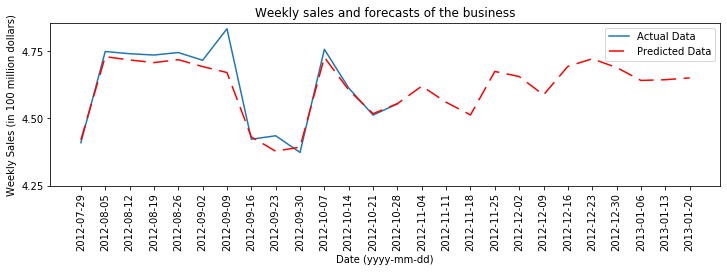

<Figure size 432x288 with 0 Axes>

In [27]:
plt.subplots(figsize=(12, 3))
plt.plot(graph_data.Date, graph_data.Weekly_Sales_x)
plt.plot(graph_data.Date, graph_data.Weekly_Sales_y, dashes=[10, 5, 10, 5], color='red')
plt.legend(['Actual Data', 'Predicted Data'], loc='upper right')
plt.yticks(np.arange(4.25, 5, 0.25))
plt.xticks(graph_data.Date, rotation=90)
plt.title('Weekly sales and forecasts of the business')
plt.xlabel('Date (yyyy-mm-dd)')
plt.ylabel('Weekly Sales (in 100 million dollars)')

plt.show()
plt.savefig('images\Weekly sales and forecasts of the business.png', bbox_inches='tight')